# Exploraty Data Analysis

## Getting started

Exploration of our data about the Drupal Community.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# 📑 Load datasets.
data = {
    'users': pd.read_parquet('../data/user.parquet'),
    'companies': pd.read_parquet('../data/organization.parquet'),
    'events': pd.read_parquet('../data/event.parquet'),
    'releases': pd.read_parquet('../data/release.parquet'),
}


In [ ]:
# Keep original values untouched.
users = data['users'].copy()
companies = data['companies'].copy()
events = data['events'].copy()
drupal = data['releases'].copy()


In [ ]:
# 📊 Merge comments with users.
comments = pd.read_parquet('../data/comment.parquet')
comments.rename(columns={'total': 'total_comments'}, inplace=True)
users.rename(columns={'id': 'uid'}, inplace=True)
if 'total_comments' not in users.columns:
    users = pd.merge(users, comments, on='uid', how='left')


## Overview

### Discovering datasets

We fetched JSON data from [Drupal.org](https://www.drupal.org/api-d7) and convert the
results to parquet files.

Let's try to get a sense of what we have available.

In [ ]:
for name in data.keys():
    df = data[name]
    display(f'{name}: {df.shape[0]} rows and {len(df.columns)} columns')
    display(df.sample(1))
    display(df.dtypes)


'users: 2093637 rows and 18 columns'

,id,title,fname,lname,created,da_membership,slack,mentors,countries,language,languages,timezone,region,city,organizations,industries,contributions,events
917899,1474748,lo4gst3dzmx8ans,<NA>,<NA>,1313174560,<NA>,<NA>,[],[],None,[],<NA>,<NA>,None,[],None,[],[]


id                        int32
title            string[python]
fname            string[python]
lname            string[python]
created                   int32
da_membership    string[python]
slack            string[python]
mentors                  object
countries                object
language                 object
languages                object
timezone         string[python]
region           string[python]
city                     object
organizations            object
industries               object
contributions            object
events                   object
dtype: object

'companies: 5071 rows and 8 columns'

,id,title,created,changed,author,url,budget,headquarters
3705,3062991,WeAreBrain,1561025813,1704863161,2758291.0,https://www.wearebrain.com,None,"Amsterdam, Kyiv, Cape Town, Lausanne, Marseille"


id                       int32
title           string[python]
created                  int32
changed                  int64
author                 float64
url                     object
budget                  object
headquarters            object
dtype: object

'events: 1234 rows and 14 columns'

,id,title,from,to,duration,event_type,event_format,author,speakers,sponsors,volunteers,organizers,city,country
898,3460599,Drupal Austria Countryside Meetup,1720375200,1720375200,0,localmeetup,in_person,80801.0,[],[],[80801],[219000],Tulln an der Donau,AT


id                       int32
title           string[python]
from                     int64
to                       int64
duration                 int64
event_type              object
event_format            object
author                 float64
speakers                object
sponsors                object
volunteers              object
organizers              object
city                    object
country                 object
dtype: object

### Table relationships

The `user` dataset is obviously central to the whole set of data. 

We can make the following relationships:

* Get **information about companies** a user is/was involved with

`data.users['organizations'][] >----< data.companies['id']`

* Get the details of **events a user has attended**

`users['id'] |----< events['uid', 'total']`


## Dimensions

Let's build a few useful dimensions to help exploration.

In [ ]:
# Build the dataframe of organizations members.
# Users and organizations are linked by the `users.organizations` and `companies.id` columns
# @todo Fix wrong organization IDs in the users table 😨.
# @see https://github.com/MatthieuScarset/drucom/issues/1
users.drop(columns=['organizations'], inplace=True)


## Data preprocessing 


### Cleaning

There are a few datetime fields we can normalize: 

* `user.created`
* `event.from`, `event.to`
* `companies.created`, `companies.changed`

In [ ]:
users = data['users'].copy()
events = data['events'].copy()

users['created'] = pd.to_datetime(users['created'], unit='s')
events['from'] = pd.to_datetime(events['from'], unit='s')
events['to'] = pd.to_datetime(events['to'], unit='s')
companies['created'] = pd.to_datetime(companies['created'], unit='s')
companies['changed'] = pd.to_datetime(companies['changed'], unit='s')


There is a lot of empty values.

In [ ]:
missing_values = users.isnull().sum()
missing_values = missing_values[missing_values > 0]
display('--- Sums ---', missing_values)
display('--- Shares (%) --', missing_values/len(users) * 100)


'--- Sums ---'

fname            1609139
lname            1620054
da_membership    2090968
slack            2090244
language         2080667
timezone         1425587
region           1426273
city             1426273
industries       2093637
dtype: int64

'--- Shares (%) --'

fname             76.858548
lname             77.379890
da_membership     99.872518
slack             99.837938
language          99.380504
timezone          68.091412
region            68.124178
city              68.124178
industries       100.000000
dtype: float64

Text(0.5, 1.0, 'Missing values in users dataframe')

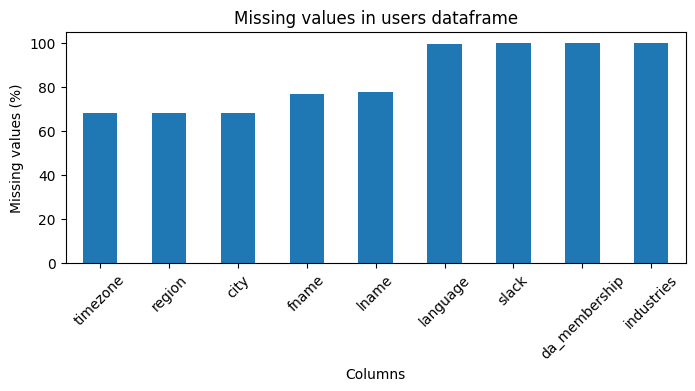

In [ ]:
# Plot the missing values.
plt.figure(figsize=(8, 3))
shares = missing_values / len(users) * 100
shares.sort_values(ascending=True).plot(kind='bar')
# Rotate the x-axis labels for better readability.
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Missing values (%)')
plt.title('Missing values in users dataframe')


Drop useless columns: 

* `industries` column is totally empty
* `timezone` was already splitted into `region` and `city` during fetching


In [ ]:
for col in ['timezone', 'industries']:
    if col in users.columns:
        users.drop(columns=[col], inplace=True)


It strikes us that first and last name columns are almost empty (e.g. `fname`, `lname`) with 80% of missing values, rougthly 1.7 millions rows out of 2.1 millions in total. It is suprising such *basic information* is missing from a dataset about a *social community*. We cannot know for sure but it is probably a combination of reasons:

1. 👨‍💻 The community is historically a developer community who tend to use pseudo before real names
2. 🪬 Users registered on Drupal.org cares about some sort of privacy
3. 🐖 Many are SPAM accounts

Let's classify people with no names as `anonymous` for the rest of the exploration.

Text(0, 0, '76.5%')

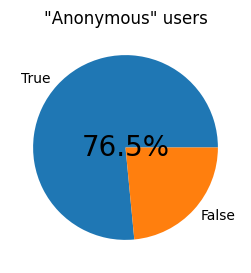

In [ ]:
users['anonymous'] = users['fname'].isnull() & users['lname'].isnull()

# Show the percentage of "Anonymous" users.
plt.figure(figsize=(8, 3))
users.anonymous.value_counts().plot(
    kind='pie', legend=False, title='Anonymous users')
plt.xlabel('')
plt.ylabel('')
plt.title('"Anonymous" users')
plt.text(
    0, 0, f'{users.anonymous.value_counts()[True] / len(users) * 100:.1f}%', ha='center', va='center', fontsize=20)


## Exploratory Data Analysis

### To dos

* User profiling

### Trends

Our dataset contains very few indicators of evolutions in time except the following:

* `users.created`: users registration date on *d.o*
* `companies.created`: date of first publication of an organization on *d.o*
* `companies.changed`: latest update of an organization
* `events.from`: date of events published on *d.o*

Text(0.5, 1.0, 'User registrations per year')

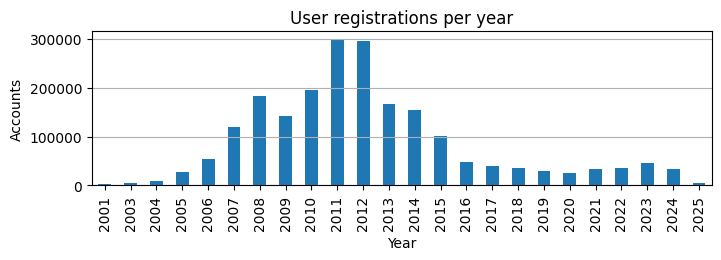

In [ ]:
plt.figure(figsize=(8, 2))
users['created'].dt.year.value_counts(
).sort_index().plot(kind="bar", legend=False)
plt.xlabel("Year")
plt.ylabel("Accounts")
plt.grid(axis='y')
plt.title("User registrations per year")


The only numerical data we can *describe* in the registration date.

In [ ]:
users['created'].describe()


count                          2093637
mean     2012-08-26 19:35:06.475002624
min                2001-03-31 11:43:00
25%                2009-11-06 15:05:58
50%                2012-01-10 20:21:42
75%                2014-06-21 14:46:53
max                2025-03-26 19:30:33
Name: created, dtype: object